# Initialization

In [28]:
import pandas as pd
import numpy as np
import scipy.integrate
from CoolProp.CoolProp import PropsSI
import cantera as ct
print('Runnning Cantera version: ' + ct.__version__)

Runnning Cantera version: 2.4.0


In [45]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = [12.0, 6.0]
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['savefig.dpi'] = 120

# Font
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
mpl.rc('font', **font)

# Style
plt.style.use(['science', 'grid'])

In [104]:
np.set_printoptions(precision=2)

# Defining Reaction Mechanism

## Mechanism II - Marinov + Mevel

In [234]:
marinov_species = ct.Species.listFromFile('marinov_ethanol_mechanism.cti')
marinov_reactions = ct.Reaction.listFromFile('marinov_ethanol_mechanism.cti')

mevel_species = ct.Species.listFromFile('mevel_ethanol_mechanism.cti')
mevel_reactions = ct.Reaction.listFromFile('mevel_ethanol_mechanism.cti')

new_species = []
new_reactions = []

# Filter species
for specie in mevel_species:
    # Include all nitrogen compounds except for N2
    if 'N' in specie.composition and specie.composition != {'N':2}: new_species.append(specie)

new_species_names = {specie.name for specie in new_species}
# print('N based species: {0}'.format(', '.join(name for name in new_species_names)))

marinov_mevel_species = marinov_species + new_species
marinov_mevel_species_names = {specie.name.upper() for specie in marinov_mevel_species}

# Filter reactions, keeping only those that only involve the selected species
# print('\nReactions:')
for R in mevel_reactions:
    if any(reactant in new_species_names for reactant in R.reactants) or any(product in new_species_names for product in R.products):
        # for reactant in R.reactants:
            # if reactant not in marinov_mevel_species_names:
                # print('Missing reactant:', reactant, 'when analyzing reaction', R.equation)
        # for product in R.products:
            # if product not in marinov_mevel_species_names:
                # print('Missing product:', product, 'when analyzing reaction', R.equation)
        if all(reactant in marinov_mevel_species_names for reactant in R.reactants):
            if all(product in marinov_mevel_species_names for product in R.products):
                new_reactions.append(R)
                # print('Accepted reaction:', R.equation)
# print('\n')

marinov_mevel_species = marinov_species + new_species
marinov_mevel_reactions = marinov_reactions + new_reactions

marinov_mevel_gas = ct.Solution(
    thermo='IdealGas',
    kinetics='GasKinetics',
    species=marinov_mevel_species,
    reactions=marinov_mevel_reactions
)

marinov_mevel_gas = ct.Solution('sandiego2016_plus_N_CK.cti')
print('Number of species:', marinov_mevel_gas.n_species)
print('Number of reactions:', marinov_mevel_gas.n_reactions)



**** WARNING ****
For species C2H4OOH, discontinuity in cp/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  18.4211
	Value computed using high-temperature polynomial: 18.7409


**** WARNING ****
For species C2H4OOH, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  14.778
	Value computed using high-temperature polynomial: 14.7264


**** WARNING ****
For species OC2H3OOH, discontinuity in cp/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  18.7616
	Value computed using high-temperature polynomial: 19.0815


**** WARNING ****
For species OC2H3OOH, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  -18.695
	Value computed using high-temperature polynomial: -18.741


**** WARNING ****
For species CH2CH2OH, discontinuity in cp/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  15.1078
	Value computed using high-tempe

# Thermodynamic Properties

## Calculation in Equilibrium - Constant Temperature and Pressure

In [279]:
# Define the reactor temperature and pressure
def enthalpy(gas, T, P, phi):
    # gas: Cantera Solution
    # T: temperature in K
    # P: pressure in Pa
    # phi: equivalence ratio
    
    # gas.enthalpy_mass: J/kg
    
    # print(T, phi)
    
    # Set initial state
    gas.TP = T, P
    gas.set_equivalence_ratio(phi, fuel='C2H5OH', oxidizer='N2O')
    
    # Calculate equilibrium under constant temperature and pressure
    gas.equilibrate('TP')
    
    return gas.enthalpy_mass

def enthalpy_partial_T(gas, T, P, phi, dT=1):
    return (enthalpy(gas, T+dT, P, phi) - enthalpy(gas, T, P, phi))/(dT)

def enthalpy_partial_phi(gas, T, P, phi, dphi=1e-8):
    return (enthalpy(gas, T, P, phi+dphi) - enthalpy(gas, T, P, phi))/(dphi)

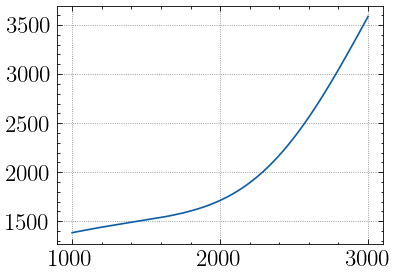

In [280]:
plt.figure()
T_mesh = np.linspace(1000, 3000, 1000)
plt.plot(T_mesh, np.vectorize(enthalpy_partial_T)(marinov_mevel_gas, T_mesh, 35e5, 1.0))
plt.show()

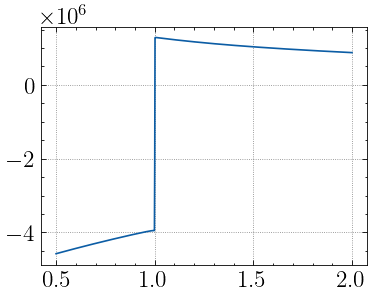

In [276]:
plt.figure()
Phi_mesh = np.linspace(0.5, 2.0, 1000)
plt.plot(Phi_mesh, np.vectorize(enthalpy_partial_phi)(marinov_mevel_gas, 1500, 35e5, Phi_mesh))
plt.show()

# Reactor Model

In [328]:
# Constants
A = np.pi*(35/1000)**2
P = 35e5
h_l = PropsSI('H','P',P,'Q',0,'Ethanol')
h_fg = PropsSI('H','P',P,'Q',1,'Ethanol') - h_l
T_boil = PropsSI('T','P',P,'Q',0,'Ethanol')
rho_l =  PropsSI('D','P',P,'Q',0,'Ethanol')
FOst = 0.17445603193

# Intial conditions
D_0 = 24.6*1e-6 # micro m
D2_0 = (D_0*1e6)**2
ml_0 = 77/1000 # kg/s
mg_0 = 418/1000 # kg/s
phi_0 = 0.0
T_0 = 600 # K
v_d_0 = 75.0 # m/s
N_dot = 6*ml_0/(rho_l*np.pi*D_0**3)

u_0 = np.array([D2_0, ml_0, mg_0, phi_0, T_0, v_d_0])

done = False

def dudx(u, x):
    global done
    # Get variables from state vector
    D2, ml, mg, phi, T, v_d = u
    D = (D2**0.5)*1e-6
    
    # print('u:', u)
    
    if done or D2 < 1e-3 or ml < 1e-5:
        done = True
        return np.array([0, 0, 0, 0, 0, 0])
    
    # Set gas condition
    marinov_mevel_gas.TP = T, P
    marinov_mevel_gas.set_equivalence_ratio(phi, fuel='C2H5OH', oxidizer='N2O')
    
    # Compute dD^2/dx
    T_bar = 0.5*T + 0.5*T_boil
    try:
        k_v = PropsSI('conductivity','T', T_bar, 'P',P,'Ethanol')
        marinov_mevel_gas.TP = T_bar, P
        k_inf = marinov_mevel_gas.thermal_conductivity # PropsSI('conductivity','T', T, 'P', P, 'Air')
        marinov_mevel_gas.TP = T, P
        kg = 0.4*k_v + 0.6*k_inf
        c_pv = PropsSI('Cp0mass','T', T_bar, 'P', P, 'Ethanol')
        K = 8*kg/(rho_l*c_pv) * np.log(1 + c_pv*(T - T_boil)/h_fg)
    except:
        print('error')
        K = 7.25327259695447e-07
    dD2_dx = -K/v_d * 1e12
    # print(f'K: {K:0.2e}')
    
    # Compute dml_dx and dmg_dx
    dml_dx = np.pi/4 * N_dot * rho_l * D * dD2_dx * 1e-12
    dmg_dx = -dml_dx
    
    # Compute dphi_dx
    dphi_dx = 1/(FOst) * dmg_dx /mg_0 
    
    # Compute dT_dx
    h_g = enthalpy(marinov_mevel_gas, T, P, phi)
    dh_dT = enthalpy_partial_T(marinov_mevel_gas, T, P, phi)
    dh_dphi = enthalpy_partial_phi(marinov_mevel_gas, T, P, phi)
    dT_dx = ((h_g - h_l)*dml_dx/mg - dh_dphi*dphi_dx)/dh_dT
    
    # Compute dvd_dx
    Ru = ct.gas_constant
    MWg = marinov_mevel_gas.mean_molecular_weight
    v_g = (mg*Ru*T)/(MWg*P*A)
    # print(f'v_g: {v_g:0.2f}')
    v_rel = v_d - v_g
    rho_g = marinov_mevel_gas.density_mass
    mu_g = marinov_mevel_gas.viscosity # PropsSI('viscosity','T', T, 'P', P, 'Air') # Pa*s
    Re = rho_g*abs(v_d - v_g)*D/mu_g
    Cd = 24/Re + 6/(1+np.sqrt(Re)) + 0.4
    dvd_dx = -(3*Cd*rho_g*v_rel**2)/(4*rho_l*v_d*D)*v_rel/abs(v_rel)
    
    # Return du/dx
    du_dx = np.array([dD2_dx, dml_dx, dmg_dx, dphi_dx, dT_dx, dvd_dx])
    # print(f'x: {100*x:0.2f}', '| dudx:', du_dx)
    return du_dx

In [329]:
# Droplet lifetime (ms)
1000*D2_0*1e-12/7.25327259695447e-07


0.8343268392450834

# Solution and Results

In [330]:
x_mesh = np.linspace(0, 81/1000, 1000)
sol = scipy.integrate.odeint(dudx, u_0, x_mesh)

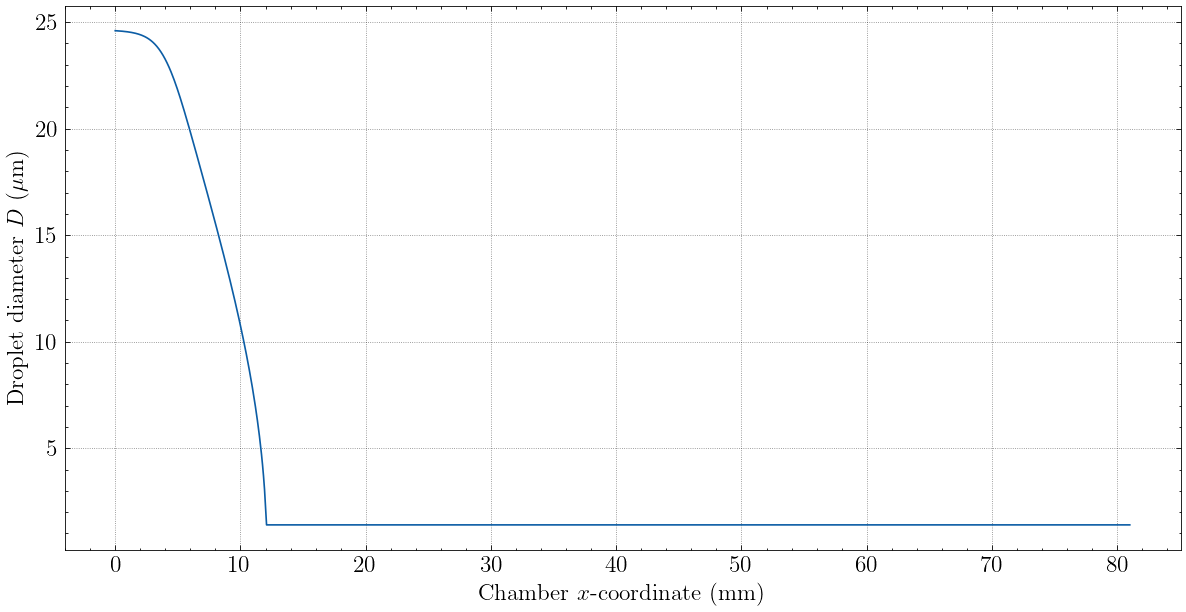

In [331]:
plt.figure(figsize=(12,6))
plt.plot(1000*x_mesh, np.sqrt(sol[:, 0]))
plt.xlabel('Chamber $x$-coordinate (mm)')
plt.ylabel('Droplet diameter $D$ ($\mu$m)')
plt.show()

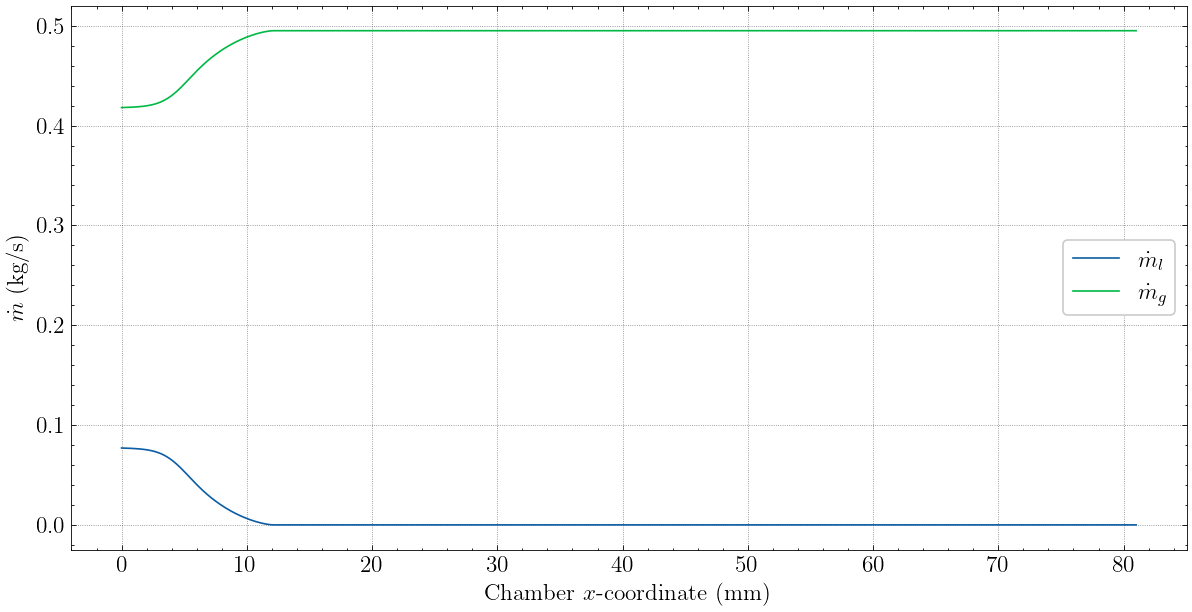

In [332]:
plt.figure(figsize=(12,6))
plt.plot(1000*x_mesh, sol[:, 1], label=r'$\dot{m}_{l}$')
plt.plot(1000*x_mesh, sol[:, 2], label=r'$\dot{m}_{g}$')
plt.xlabel('Chamber $x$-coordinate (mm)')
plt.ylabel('$\dot{m}$ (kg/s)')
plt.legend()
plt.show()

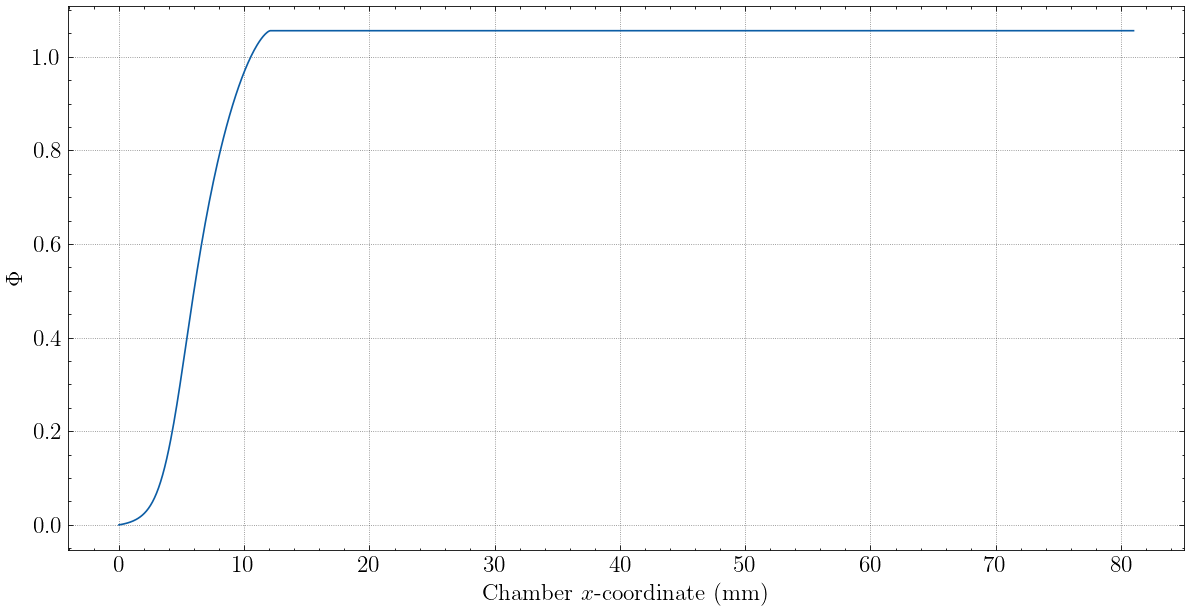

In [333]:
plt.figure(figsize=(12,6))
plt.plot(1000*x_mesh, sol[:, 3])
plt.xlabel('Chamber $x$-coordinate (mm)')
plt.ylabel('$\Phi$')
plt.show()

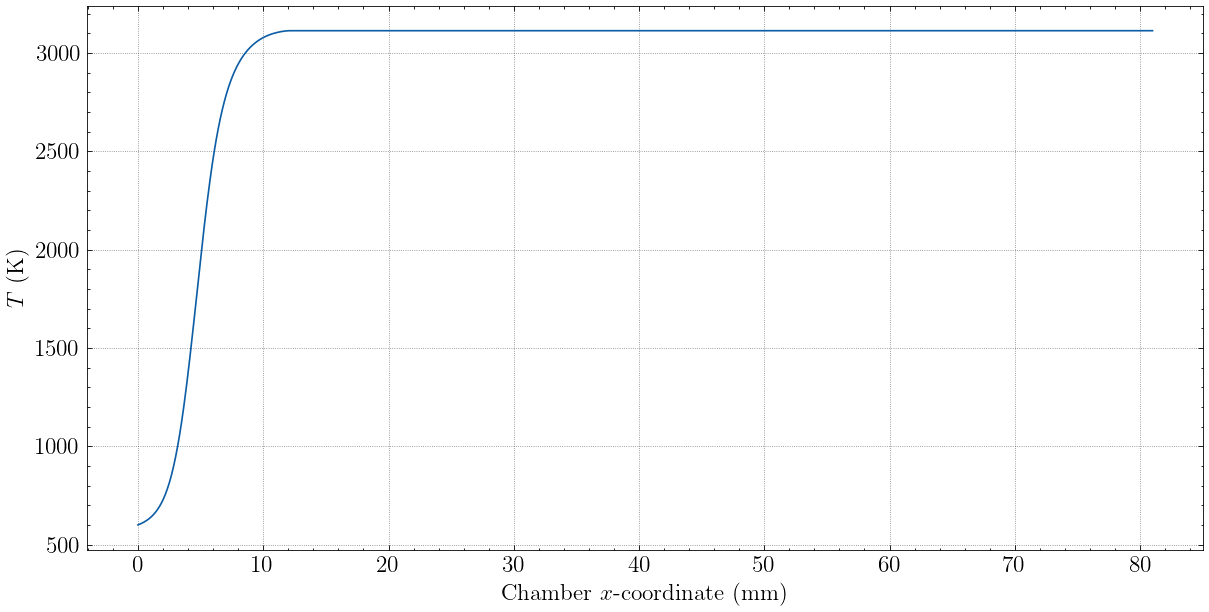

In [334]:
plt.figure(figsize=(12,6))
plt.plot(1000*x_mesh, sol[:, 4])
plt.xlabel('Chamber $x$-coordinate (mm)')
plt.ylabel('$T$ (K)')
plt.show()

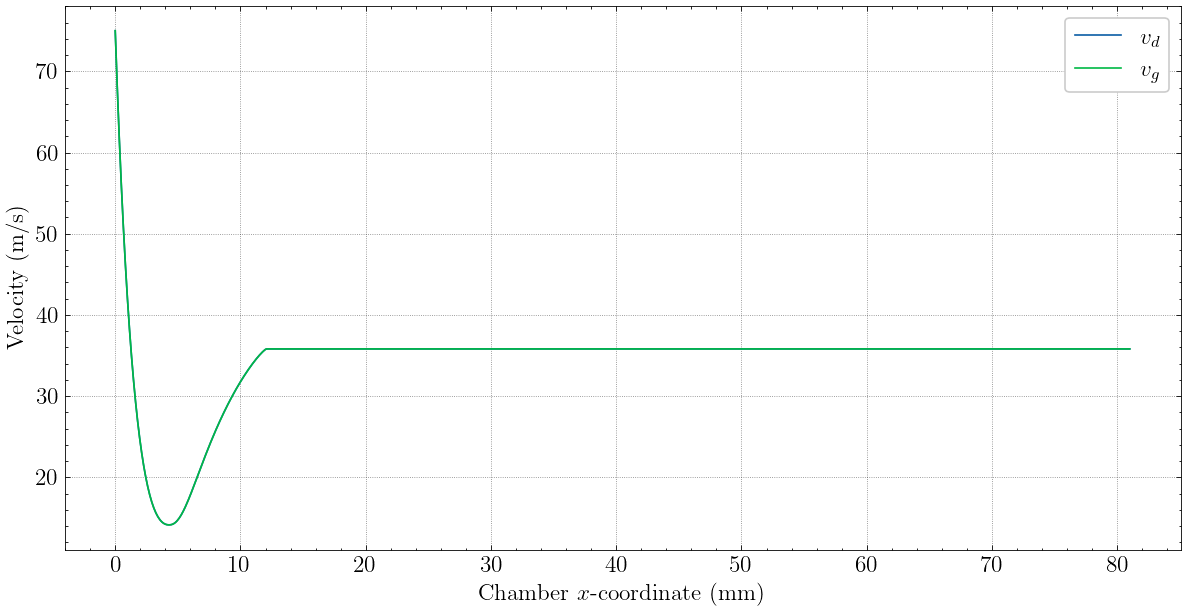

In [335]:
plt.figure(figsize=(12,6))
plt.plot(1000*x_mesh, sol[:, 5], label='$v_d$')
plt.plot(1000*x_mesh, sol[:, 5], label='$v_g$')
plt.xlabel('Chamber $x$-coordinate (mm)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.show()